### Note there is code in here that should be turned into functions and added to the libaray

In [1]:
import sys
import os

dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)
print(parent_path)

/Users/louis/Projects/Toliman


In [2]:
from lib.formatter import *
from lib.FT_modelling import scale_pupil
import numpy as np
import matplotlib.pyplot as plt

# Plotting imports
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patches as patches

# STL file creation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits import mplot3d

from matplotlib.tri import Triangulation
from stl import mesh

In [3]:
def phase_to_depth(comp_array, wl, n1, n2):
    """
    Converts a phase value (-pi, pi) to a depth for a specified wavelength
    """
    depth_array = (np.angle(comp_array) * wl) / (2 * np.pi * (n2 - n1))
    return depth_array

In [18]:
# file_name = "../Toliman_files/Toliman_Leiden_designs/Toliman_final_4000numpix_5umpix_pw5.fits"
file_name = "pupil.fits"

# Set this
# npix = 1600
npix = 800 # 25 micron resolution

raw = 4000
ratio = npix/raw

pupil = scale_pupil(pupil_from_fits(file_name), npix)

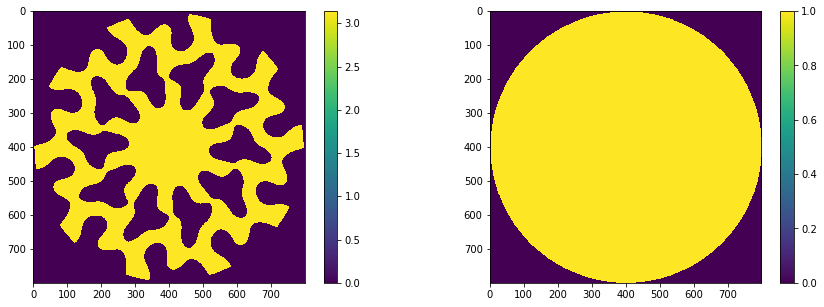

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(np.angle(pupil))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.abs(pupil))
plt.colorbar()

plt.show()

--- 
Create masks of the pupil to apply the side lobe grating to the different regions

In [20]:
# Get masks to apply gratings
outer = np.abs(pupil) == 0
norm_phase = np.logical_and(np.abs(pupil) != 0, np.angle(pupil) == 0)
anti_phase = np.logical_and(np.abs(pupil) != 0, 
                                np.logical_or(np.angle(pupil) == np.pi, np.angle(pupil) == -np.pi))

---
Create grating and anti-phase grating

In [21]:
# Grating period of 100 microns, amplitude of 100nm, resolution of 5 microns
aperture = 20e-3 # 18mm aperture
resolution = aperture/npix
print(resolution)

# Amplitude
A_max = 100e-10
A = A_max/2

# Period
period = 100e-6
period_pix = period/resolution
B = 2*np.pi / period_pix

# Create meshgrid
Xs = np.linspace(0, pupil.shape[0], num=pupil.shape[0], endpoint=False)
X, Y = np.meshgrid(Xs, Xs)

# Creating gratings
grating = (A*np.sin(B*Y) + A*np.sin(B*X))/2
anti_grating = (A*np.sin(B*Y + np.pi) + A*np.sin(B*X + np.pi))/2

2.5e-05


---
Demostrate the anti-phase relationship

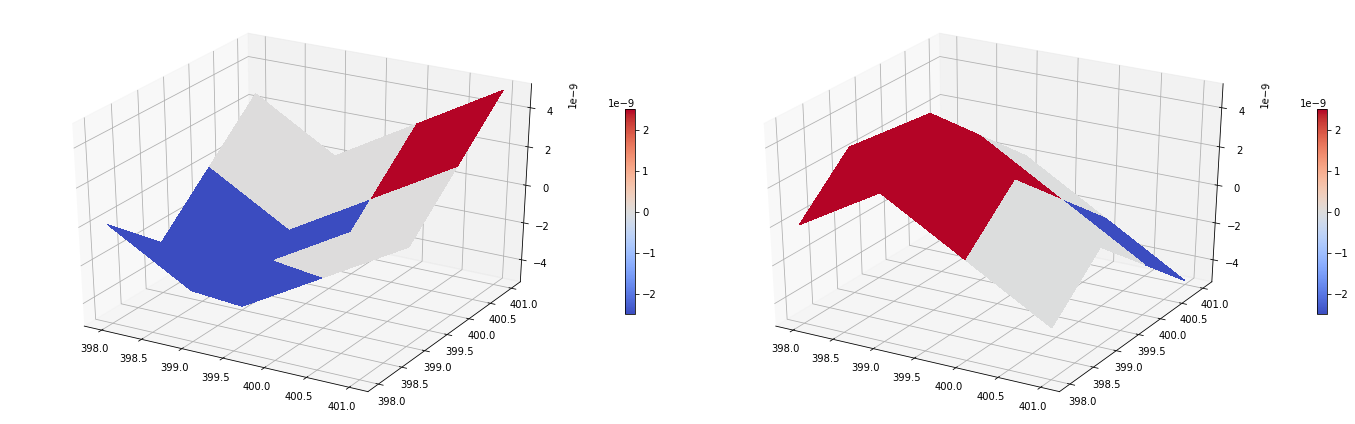

In [22]:
c = pupil.shape[0]//2
s = int(12 * ratio)
# s = int(12*5 * ratio)

# Plot
fig = plt.figure(figsize=(20,6))

# Plot one
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X[c-s:c+s, c-s:c+s], Y[c-s:c+s, c-s:c+s], grating[c-s:c+s, c-s:c+s], 
                       cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5)#, aspect=5)

# Plot two
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X[c-s:c+s, c-s:c+s], Y[c-s:c+s, c-s:c+s], anti_grating[c-s:c+s, c-s:c+s], 
                       cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5)#, aspect=5)

fig.tight_layout()
plt.show()

---
Convert the pupil from units of phase to units of depth

In [23]:
pupil_depth = phase_to_depth(pupil, 635e-9, 1, 1.455)

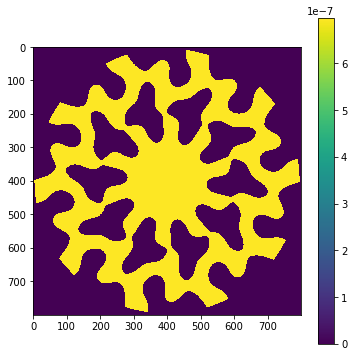

In [24]:
plt.figure(figsize=(6,6))
plt.imshow(pupil_depth)
plt.colorbar()
plt.show()

---
Use the masks to apply the phase gratings to the different regions

In [25]:
pupil_real = ((pupil_depth + grating) * norm_phase + (pupil_depth + anti_grating) * anti_phase)
size = int(200 * ratio)

x1 = 0
y1 = 0
cut_1 = pupil_real[y1:y1+size, x1:x1+size]

x2 = int(2400 * ratio)
y2 = int(200 * ratio)
cut_2 = pupil_real[y2:y2+size, x2:x2+size]

x3 = int(2800 * ratio)
y3 = int(200 * ratio)
cut_3 = pupil_real[y3:y3+size, x3:x3+size]

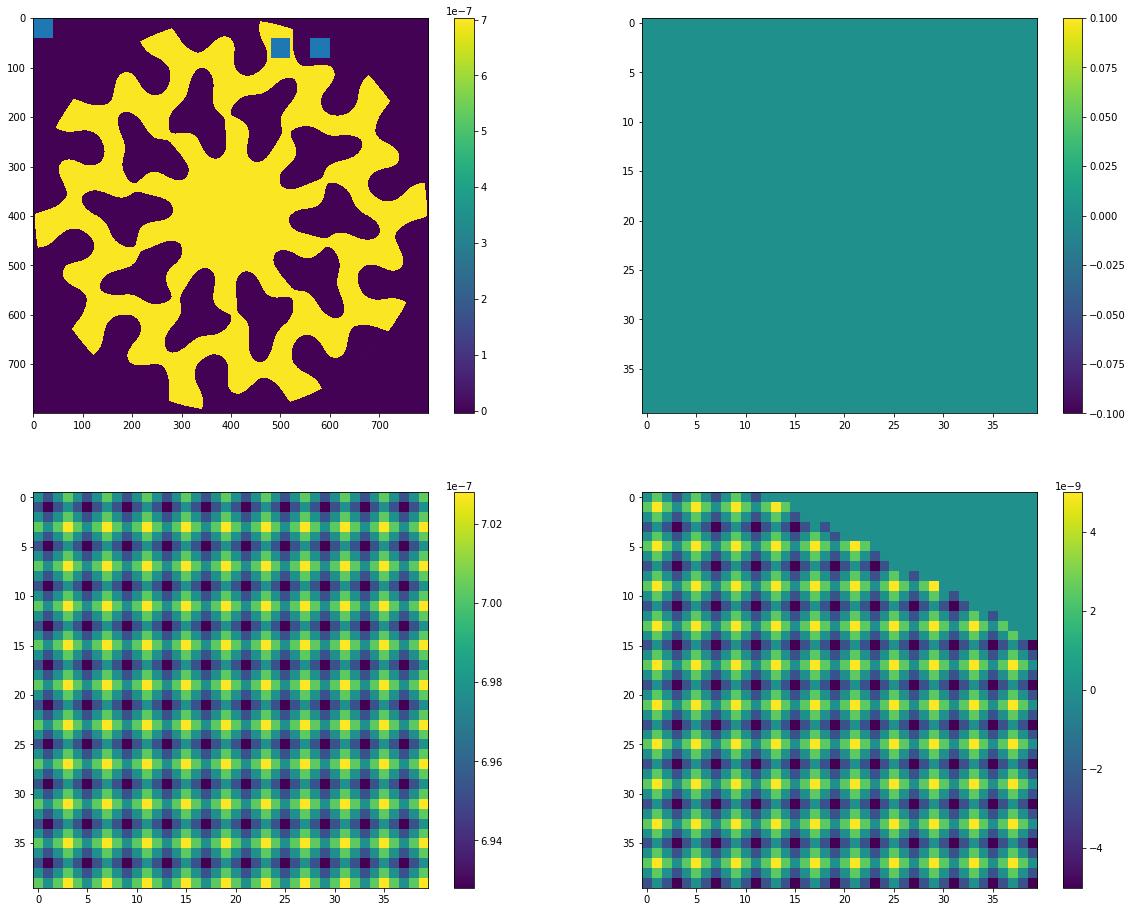

In [26]:
plt.figure(figsize=(20,16))

ax = plt.subplot(2,2,1)
plt.imshow(pupil_real)
ax.add_patch(patches.Rectangle((x1, y1), size, size))
ax.add_patch(patches.Rectangle((x2, y2), size, size))
ax.add_patch(patches.Rectangle((x3, y3), size, size))
plt.colorbar()


plt.subplot(2,2,2)
plt.imshow(cut_1)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(cut_2)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(cut_3)
plt.colorbar()
plt.show()

Note the two bottom images are separated by in integer number of grating cycles. From this we can see the anti-phase relationship between the two regions of the pupil

---

In [27]:
# Z = npix*pupil_real/np.max(pupil_real)

In [28]:
# %%time

# # Plot
# fig = plt.figure(figsize=(20,15))

# # Plot one
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# surf = ax.plot_trisurf(X.flatten(), Y.flatten(), pupil_real.flatten(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
# fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_zlim3d(0,1e-5)
# ax.view_init(60, -60)

# plt.show()

In [29]:
%%time

Z = np.array(np.round(pupil_real*1e9), dtype=np.int16())
points = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
"""
Method: Decompose the traveral pattern into a series of simpler patters
and combine them to get the final pattern.

For a gridsize of N, we have N-1 squares in each row/column, giving a 
total of (N-1)^2 sqaures and 2*(N-1)^2 triangles

Each triangle is composed of three points and a so a square is made of 6 points

Within the series of points there is a repeating pattern which can be 
decomposed into thee different sequences and combines

S1: [0,0,0], [1,1,1], [1,1,1], [2,2,2], [2,2,2], [3,3,3], ... 
S2: [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], ...
S3: [N,N,N], [0,0,0], [N,N,N], [0,0,0], [N,N,N], [0,0,0], ...
Combining these together gives us our repeating pattern, S = S1 + S2 + S3

# Note these brackes are there to help define the repeating sequence and
do not relate to the final grouping into triangles.

The final sequence is then [0, 1, S, N-1] and represents a full row of triangles
This final sequence is then repeated again with N added to each value, then
again with 2*N added to each value and so on.

"""

# Gridsize
N = npix

# Other Numer of trianges and squares
squares_per_row = N-1 
triangles_per_row = 2 * squares_per_row
num_squares = squares_per_row**2
num_triangles = 2*num_squares

# Points per triangle and square
points_per_triangle = 3
points_per_square = 2 * points_per_triangle

# Number of points per row
points_per_row = squares_per_row * points_per_square

# Size of the sequences
sequence_size = points_per_row - 3
full_sequence_size = sequence_size + 3

# Create indexes used to create sequences
i = np.linspace(0, sequence_size, num=sequence_size, endpoint=False)
j = np.floor_divide(i, 3)

# Sequence 1
S1 = np.floor_divide(j+1, 2)

# Sequence 2
S2_mask = (i+1)%3 == 0
S2 = np.ones(sequence_size)*S2_mask

# Sequence 3
S3_mask = j%2 == 0
S3 = N*np.ones(sequence_size)*S3_mask

# Add together
S = S1 + S2 + S3

# non repeating start and end of array
start = np.array([0, 1])
end = np.array([squares_per_row])

# Combine
sequence = np.concatenate([start, S, end])
base_sequence = np.tile(sequence, reps=squares_per_row)

# Create meshgrid of integer N values for the different rows
arr_x = np.linspace(0, full_sequence_size, num=full_sequence_size, endpoint=False)
arr_y = np.linspace(0, squares_per_row, num=squares_per_row, endpoint=False)
X, Y = np.meshgrid(arr_x, arr_y)
incremental_sequence = N*Y.flatten() # Flatten here in order to combine

# Combine sequences together to create final array
full_sequence_flat = base_sequence + incremental_sequence
full_sequence = full_sequence_flat.reshape([num_triangles,3])

# Force integer values
full_sequence = np.array(full_sequence, dtype=np.int64())
# print(full_sequence)

# Create the vertices and points arrays
vertices = points
faces = full_sequence
# print(vertices.shape)
# print(faces.shape)

# Create the mesh object
grid_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))

# input mesh vectors
for i, f in enumerate(faces):
    for j in range(3):
        grid_mesh.vectors[i][j] = vertices[f[j],:]

CPU times: user 6.37 s, sys: 160 ms, total: 6.53 s
Wall time: 6.85 s


In [42]:
# grid_mesh.update_units()
dir(grid_mesh)

['_Logged__get_name',
 '__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_areas',
 '_ascii_reader',
 '_get_or_update',
 '_load_ascii',
 '_load_binary',
 '_set',
 '_units',
 '_write_ascii',
 '_write_binary',
 'areas',
 'attr',
 'check',
 'data',
 'debug',
 'dtype',
 'error',
 'exception',
 'from_file',
 'from_files',
 'from_multi_file',
 'get',
 'get_mass_properties',
 'info',
 'is_closed',
 'items',
 'keys',
 'load',
 'log',
 'logger',
 'max_',
 'min_',
 'name',
 'normals',
 'points',
 'remove_duplicate_polygons',
 'remove_empty_a

In [49]:
grid_mesh.v0

array([[  0.,   0.,   0.],
       [  0.,   1.,   0.],
       [  1.,   0.,   0.],
       ...,
       [797., 799.,   0.],
       [798., 798.,   0.],
       [798., 799.,   0.]], dtype=float32)

In [ ]:
# Write the mesh to file
# grid_mesh.save('grid_mesh.stl')

In [ ]:
# Viewing code 
# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('grid_mesh.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
# scale = your_mesh.points.flatten(-1)
# axes.auto_scale_xyz(scale, scale, scale)
axes.set_xlim(50)
axes.set_ylim(50)
axes.set_zlim(-5, 5)

# axes.set_zlim3d(0,1e-5)
axes.view_init(60, -60)

# Show the plot to the screen
plt.show()

In [17]:
dir(grid_mesh)

['_Logged__get_name',
 '__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_ascii_reader',
 '_get_or_update',
 '_load_ascii',
 '_load_binary',
 '_set',
 '_write_ascii',
 '_write_binary',
 'areas',
 'attr',
 'check',
 'data',
 'debug',
 'dtype',
 'error',
 'exception',
 'from_file',
 'from_files',
 'from_multi_file',
 'get',
 'get_mass_properties',
 'info',
 'is_closed',
 'items',
 'keys',
 'load',
 'log',
 'logger',
 'max_',
 'min_',
 'name',
 'normals',
 'points',
 'remove_duplicate_polygons',
 'remove_empty_areas',
 'rotate',
 'ro